<a href="https://colab.research.google.com/github/sgulyano/aic402/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIC-402 Lab 4: Anomaly Detection

CMKL University

By Sarun Gulyanon


### Goal

In this lab, we explore anomaly detection techniques for identifying unusual or rare patterns in data using unsupervised learning methods.


### Outline

In this lab, we will explore the following topics:

1. Anomaly Detection Using Gaussian Mixtures
2. Anomaly Detection Using One-Class SVM
3. Anomaly Detection Using Isolation Forest

----

# 1. Anomaly Detection Using Gaussian Mixtures

Let's generate the same dataset as earliers with three ellipsoids (the one K-Means had trouble with):

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Let's train a Gaussian mixture model on the previous dataset:

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the EM algorithm estimated:

In [ ]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

In [ ]:
gm.means_

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

In [ ]:
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [ ]:
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2])

In [ ]:
gm.predict_proba(X).round(3)

array([[0.977, 0.   , 0.023],
       [0.983, 0.001, 0.016],
       [0.   , 1.   , 0.   ],
       ...,
       [0.   , 0.   , 1.   ],
       [0.   , 0.   , 1.   ],
       [0.   , 0.   , 1.   ]])

This is a generative model, so you can sample new instances from it (and get their labels):

In [ ]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [ ]:
y_new

array([0, 0, 1, 2, 2, 2])

Notice that they are sampled sequentially from each cluster.

You can also estimate the log of the _probability density function_ (PDF) at any location using the `score_samples()` method:

In [ ]:
gm.score_samples(X).round(2)

array([-2.61, -3.57, -3.33, ..., -3.51, -4.4 , -3.81])

Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [ ]:
# extra code – bonus material

resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

np.float64(0.9999999999225088)

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [ ]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

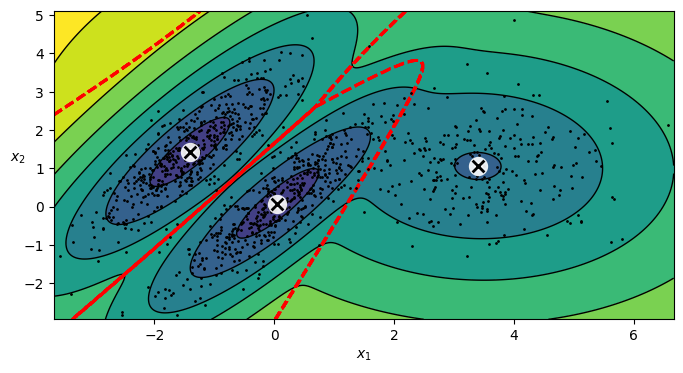

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

Gaussian Mixtures can be used for _anomaly detection_: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 2%, then you can set the density threshold to be the value that results in having 2% of the instances located in areas below that threshold density:

In [ ]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]

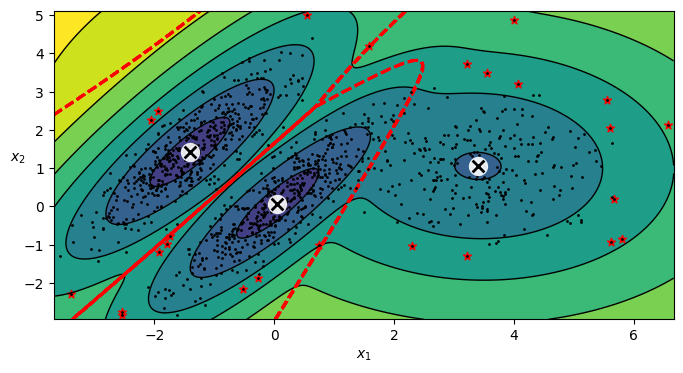

Number of anomalies detected by GMM: 25


In [ ]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

print("Number of anomalies detected by GMM:", len(anomalies))

## Selecting the Number of Clusters

We cannot use the inertia or the silhouette score because they both assume that the clusters are spherical. Instead, we can try to find the model that minimizes a theoretical information criterion such as the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC):

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$ is the number of instances.
* $p$ is the number of parameters learned by the model.
* $\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data $\mathbf{X}$, given the model and its optimized parameters.

Both BIC and AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data).

In [ ]:
gm.bic(X)

np.float64(8189.733705221636)

In [ ]:
gm.aic(X)

np.float64(8102.508425106598)

We could compute the BIC manually like this:

In [ ]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood
print(f"bic = {bic}")
print(f"aic = {aic}")
print(f"n_params = {n_params}")

bic = 8189.733705221636
aic = 8102.508425106598
n_params = 17


There's one weight per cluster, but the sum must be equal to 1, so we have one degree of freedom less, hence the -1. Similarly, the degrees of freedom for an $n \times n$ covariance matrix is not $n^2$, but $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Let's train Gaussian Mixture models with various values of $k$ and measure their BIC:

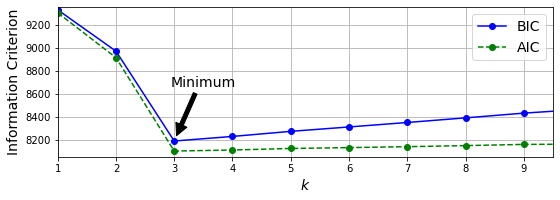

In [ ]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("Information Criterion")
plt.axis([1, 9.5, min(aics) - 50, max(aics) + 50])
plt.annotate("", xy=(3, bics[2]), xytext=(3.4, 8650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(3.5, 8660, "Minimum", horizontalalignment="center")
plt.legend()
plt.grid()
plt.show()

# 2. Anomaly Detection Using One-Class SVM

One-Class SVM model uses the boundary of normal data in a high-dimensional feature space to identify anomalies as points that lie outside this learned region. It is effective for detecting subtle anomalies but is sensitive to kernel choice and hyperparameter settings.

Number of anomalies detected by One-Class SVM: 129


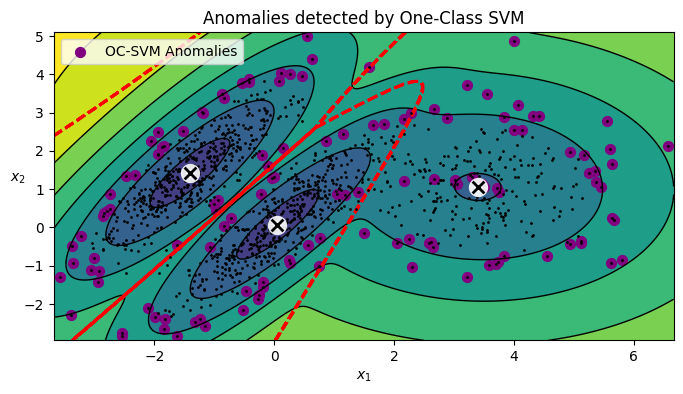

In [ ]:
from sklearn.svm import OneClassSVM

# One-Class SVM for anomaly detection
oc_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma="auto") # nu is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.
oc_svm.fit(X)
oc_svm_anomalies = X[oc_svm.predict(X) == -1]

print("Number of anomalies detected by One-Class SVM:", len(oc_svm_anomalies))

plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X) # Re-use the existing plotting function for background clusters
plt.scatter(oc_svm_anomalies[:, 0], oc_svm_anomalies[:, 1], color='purple', marker='o', s=50, label='OC-SVM Anomalies')
plt.title('Anomalies detected by One-Class SVM')
plt.ylim(top=5.1)
plt.legend()
plt.show()


# 3. Anomaly Detection Using Isolation Forest

Isolation Forest identifies anomalies by isolating data points through random feature splits. Anomalies are detected with fewer splits than normal points, making Isolation Forest efficient and effective for high-dimensional data and unlabeled datasets.

Number of anomalies detected by Isolation Forest: 125


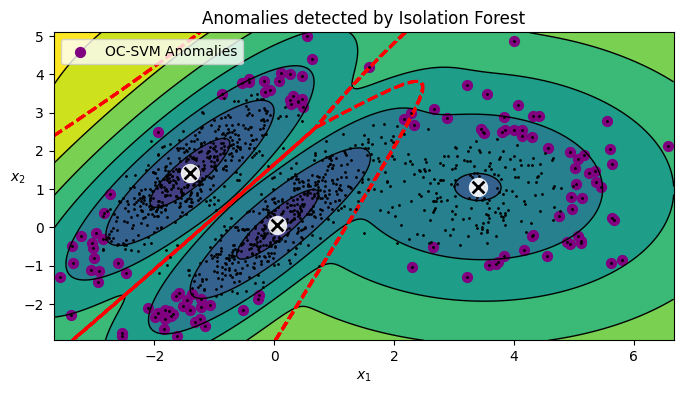

In [ ]:
from sklearn.ensemble import IsolationForest

# Isolation Forest for anomaly detection
isolation_forest = IsolationForest(contamination=0.1, random_state=42) # contamination is the proportion of outliers in the data set
isolation_forest.fit(X)
if_anomalies = X[isolation_forest.predict(X) == -1]

print("Number of anomalies detected by Isolation Forest:", len(if_anomalies))

plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.scatter(if_anomalies[:, 0], if_anomalies[:, 1], color='purple', marker='o', s=50, label='OC-SVM Anomalies')
plt.title('Anomalies detected by Isolation Forest')
plt.ylim(top=5.1)
plt.legend()
plt.show()


----